<a href="https://colab.research.google.com/github/Kristelwen/TM10007_PROJECT/blob/master/brat_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment
Kristel, Lalot, Marijn, Tahisa



---


# Outline opdracht


---


Gebaseerd op beeldvorming moeten we eruit kunnen halen wat voor een soort tumor het is?
Je wil weten of het HIGH of LOW grade is.

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Kristelwen/TM10007_PROJECT

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [0]:
# Importing modules
# General packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets as ds
from scipy.stats import randint

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# SVM Kernels
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import KernelPCA

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
# Data loading functions. Uncomment the one you want to use
# from adni.load_data import load_data
from brats.load_data import load_data
#from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 167
The number of columns: 725


In [0]:
data_top = data.head()  

# display  
# data_top 

# Preprocessing

In [0]:
# Drop columns which contain NaN values
threshold = math.floor(len(data)/2)  # calculate threshold, half of total rows
data_drop = data.dropna(thresh=threshold, axis=1)  # Delete columns/features with more than 'threshold' NaNs
data_drop = data_drop.dropna(axis=0)  # Delete rows/subjects with NaNs
# print(data_drop)

# Split data and labels
labels = data_drop['label']
data_drop = data_drop.drop(columns="label")  # Data without labels

# Convert labels 'GBM' and 'LGG' to respectively 0 and 1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Delete columns with strings (2 columns)
# data_strings = data_drop.select_dtypes(include=[object])
# columns_strings = list(data_strings.columns)
# data_no_strings = data_drop.drop(columns_strings, axis=1)

# Replace infinity values with NaN
#data_no_strings = data_no_strings.replace([np.inf, -np.inf], np.nan)
# print(np.isinf(data_no_strings.values).any()) - check if dataframe contains infinity values

# Feature scaling
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_drop.values)
data_df = pd.DataFrame(data_scaled, index = data_drop.index, columns = data_drop.columns)

# Split the data in a train (80%) and test set (20%) - OF MOET DIT VOOR FEATURE SCALING? Omdat je niks mag fitten op testdata
data_train, data_test, label_train, label_test = train_test_split(data_df, labels, test_size=0.1)
data_train2, data_val, label_train2, label_val = train_test_split(data_train, label_train, test_size=0.1)

# PCA
  # Training set 1
pca_train = PCA(n_components=80)  # Create a PCA with 20 components
pca_train.fit(data_train)  # Fit PCA
data_train_pca = pca_train.transform(data_train)  # Transform train data using PCA
df_train_pca = pd.DataFrame(data_train_pca, index = data_train.index)  # Put train data back in dataframe with 20 most important features
  # Training set 2
data_train_pca2 = pca_train.transform(data_train2)
  # Validatie set
data_val_pca = pca_train.transform(data_val)  # Transform test data using PCA

  # Test set
data_test_pca = pca_train.transform(data_test)  # Transform test data using PCA


# Learning curves & bias variance dillema

In [0]:
# print(df_train_pca)
# pd.DataFrame(data_val_pca)


## Ridgen

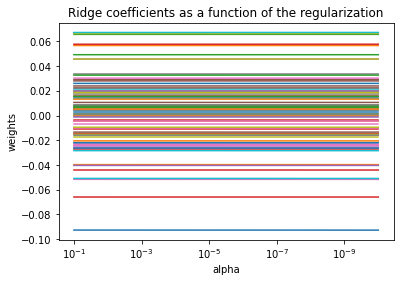

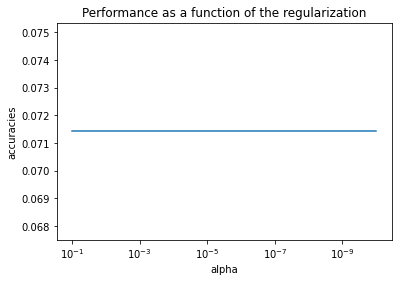

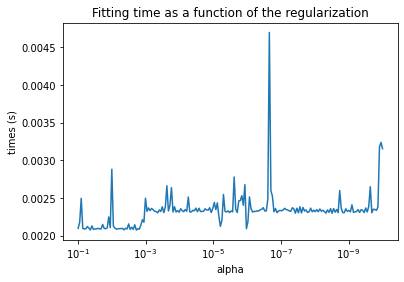

In [0]:
# Display the weights and compute error for multiple values for alpha
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = RidgeClassifier(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(data_train_pca, label_train)
    duration = time() - t0
    val_pred = clf.predict(data_val_pca)
    message = ("\t Misclassified: %d / %d" % ((label_validation != val_pred).sum(), label_validation.shape[0]))
    # print(message)
    
    # Append statistics
    accuracy = float((label_validation != val_pred).sum()) / float(label_validation.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()


## Learning Curves

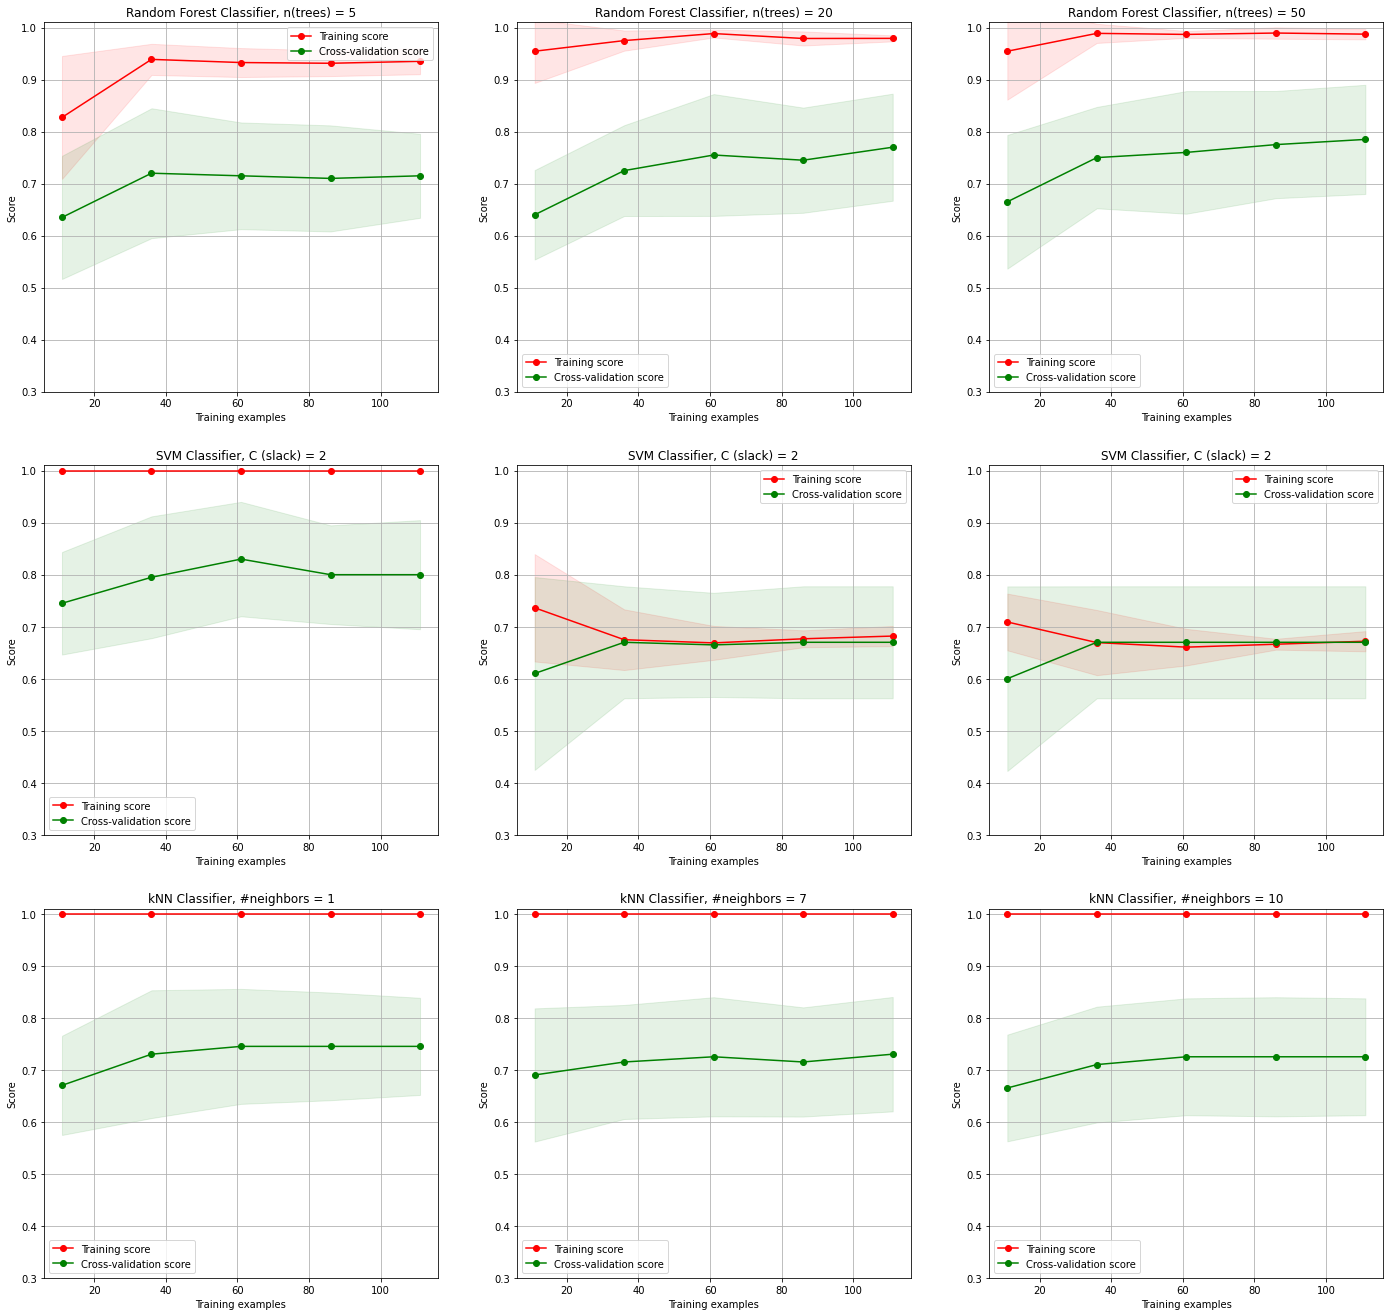

In [7]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


# First make plot without classifiers:
# Construct classifiers
svmlin = SVC(C=2, kernel='linear', gamma='scale') # linear kernel 
svmrbf = SVC(C=2, kernel='rbf', gamma='scale') # radial basis function kernel 
svmpoly = SVC(C=2, kernel='poly', degree=3, gamma='scale') # polynomial kernel

clsfs = [
         RandomForestClassifier(n_estimators=5, min_samples_leaf=3, max_features='auto', random_state=0, bootstrap=True),
         RandomForestClassifier(n_estimators=20, min_samples_leaf=3, random_state=0, bootstrap=True),
         RandomForestClassifier(n_estimators=50, min_samples_leaf=3, random_state=0, bootstrap=True),
         svmlin, svmrbf, svmpoly,
         KNeighborsClassifier(n_neighbors=1, weights='distance'),
         KNeighborsClassifier(n_neighbors=7, weights='distance'),
         KNeighborsClassifier(n_neighbors=10, weights='distance')
        ]

# Plot figuren
fig = plt.figure(figsize=(24,8*len(clsfs)))
# ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], marker='o', c=label_train,
#     s=25, edgecolor='k', cmap=plt.cm.Paired)
    
        
# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

# Now use the classifiers on all datasets
num = 0
for clf in clsfs:
    # Split data in training and testing
    # title = str(type(clf))
    if hasattr(clf, 'n_estimators'):
        title = f"Random Forest Classifier, n(trees) = {clf.n_estimators}"
    elif hasattr(clf, 'C'):
        title = f"SVM Classifier, C (slack) = {clf.C}"
    elif hasattr(clf, 'n_neighbors'):
        title = f"kNN Classifier, #neighbors = {clf.n_neighbors}"
    ax = fig.add_subplot(len(clsfs), 3, num + 1)
    plot_learning_curve(clf, title, data_train_pca, label_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1


## Random Forest Classifier

In [8]:
#default settings 
n_samples=len(data_test_pca)
homemade_random_forest = BaggingClassifier(RandomForestClassifier()) 
homemade_random_forest.fit(data_train_pca,label_train) #fit the classifier on the training set 
test=homemade_random_forest.predict(data_test_pca) #test 
error= (sum(abs(test - label_test))/n_samples)*100
error = (round(error, 2))
print ('the error when using default settings is {}%'.format(error))

print ('')#  ff voor overzicht 

#using different n_trees and bootstrapping  
n_trees=[5,10,50,100,150,200,300,400,500,600]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  clf.fit(data_train_pca2,label_train2)
  
  predictions_train = clf.predict(data_train_pca2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  
  print ('Train set: When using bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_train))

  predictions_val = clf.predict(data_val_pca)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))

  print ('Validation set: When using bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_val))

print ('')

#using different n_trees without bootstrapping  
n_trees=[5,10,50,100,150,200,300,400,500,600]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=False)
  clf.fit(data_train_pca2,label_train2)
  
  predictions_train = clf.predict(data_train_pca2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  
  print ('Train set: Without bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_train))

  predictions_val = clf.predict(data_val_pca)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))

  print ('Validation set: Without bootstrapping and {} trees, the error is {}%'.format(n_tree,errors_val))

the error when using default settings is 20.0%

Train set: When using bootstrapping and 5 trees, the error is 26.67%
Validation set: When using bootstrapping and 5 trees, the error is 26.67%
Train set: When using bootstrapping and 10 trees, the error is 6.67%
Validation set: When using bootstrapping and 10 trees, the error is 33.33%
Train set: When using bootstrapping and 50 trees, the error is 0.0%
Validation set: When using bootstrapping and 50 trees, the error is 33.33%
Train set: When using bootstrapping and 100 trees, the error is 0.0%
Validation set: When using bootstrapping and 100 trees, the error is 33.33%
Train set: When using bootstrapping and 150 trees, the error is 0.0%
Validation set: When using bootstrapping and 150 trees, the error is 33.33%
Train set: When using bootstrapping and 200 trees, the error is 0.0%
Validation set: When using bootstrapping and 200 trees, the error is 33.33%
Train set: When using bootstrapping and 300 trees, the error is 0.0%
Validation set: Wh

In [0]:
# Hyperparameter optimization of Random Forest Classifier

# Our parameter to optimize is the number of estimators, which we vary uniformlybetween 1 and 400
param_distributions = {'n_estimators': randint(1, 400)}

# Now use the classifiers on all datasets
fitted_clfs = list()
    
# Within a 5-fold cross-validation, try out 20 different number of trees
clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)

# Fit the classifier
clf.fit(data_train_pca2, label_train2)

# Save for next part
fitted_clfs.append(clf)

In [29]:
# Get the best estimator and best parameters belonging to that estimator
print(f'\n The best estimator is {clf.best_estimator_} \n The best amount of trees is {clf.best_params_}')


 The best estimator is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=215,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
 The best amount of trees is {'n_estimators': 215}


In [33]:
#Random Forest classifier as a function 
def RandomForest(n_trees,data_train_pca2,data_val_pca,labels_train2,labels_val):
  clf = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
  clf.fit(data_train_pca2,label_train2)
  predictions_train = clf.predict(data_train_pca2)
  n_samples=len(data_train_pca2)
  errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
  errors_train = (round(errors_train, 2))
  accuracy_train=100-errors_train

  clf.fit(data_val_pca,label_val)
  predictions_val = clf.predict(data_val_pca)
  n_samples=len(data_val_pca)
  errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
  errors_val = (round(errors_val, 2))
  accuracy_val=100-errors_val

  return (accuracy_train, accuracy_val)

acc = RandomForest(15,data_train_pca2,data_val_pca,label_train2,label_val)
print(f'Accuracy of Random Forest Classifier for the training set is {acc[0]} and for the validation set is {acc[1]}')

Accuracy of Random Forest Classifier for the training set is 100.0 and for the validation set is 100.0


In [34]:
predictions_test = clf.predict(data_test_pca)
n_samples=len(data_test_pca)
errors_test = (sum(abs(predictions_test - label_test))/n_samples)*100
errors_test = (round(errors_test, 2))
accuracy_test=100-errors_test

print(f'Accuracy of Random Forest Classifier for the test set is {accuracy_test}')

Accuracy of Random Forest Classifier for the test set is 93.33


## Support Vector Machine

In [60]:
#Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale') # linear kernel 
svmrbf = SVC(kernel='rbf', gamma='scale') # radial basis function kernel 
svmpoly = SVC(kernel='poly', degree=3, gamma='scale') # polynomial kernel

clsfs = [svmlin, svmrbf, svmpoly]

for clf in clsfs: # voor alle classifiers in lijst
   clf.fit(data_train_pca, label_train) # fit classifier op trainingsset
   test = clf.predict(data_test_pca) # test classifier op testset
   error = (sum(abs(test - label_test))/len(data_test))*100 # hoevaak fout? 
   error = (round(error, 2))
   accuracy = 100 - error
   #print(f'The Accuracy of SVM is {accuracy}%')

# functie
def SVM(clsfs, data_train_pca2, data_val_pca, label_train2, label_val): 
    accuracies_train = list()
    accuracies_val = list()

    for clf in clsfs:
      clf.fit(data_train_pca2,label_train2)
      predictions_train = clf.predict(data_train_pca2)
      n_samples=len(data_train_pca2)
      errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
      errors_train = (round(errors_train, 2))
      accuracy_train=100-errors_train
      accuracies_train.append(accuracy_train)
      
      clf.fit(data_val_pca,label_val)
      predictions_val = clf.predict(data_val_pca)
      n_samples=len(data_val_pca)
      errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
      errors_val = (round(errors_val, 2))
      accuracy_val=100-errors_val
      accuracies_val.append(accuracy_val)

    return (accuracies_train, accuracies_val)

accuracies_train, accuracies_val = SVM(clsfs, data_train_pca2, data_val_pca, label_train2, label_val)

clsfs_names = ['SVM with linear kernel', 'SVM with radial basis function kernel', 'SVM with polynomial kernel']
for num, acc_train in enumerate(accuracies_train):
    print(f'\n The accuracy of {clsfs_names[num]} is {acc_train}% for the train set and {accuracies_val[num]}% for the validation set')



 The accuracy of SVM with linear kernel is 100.0% for the train set and 100.0% for the validation set

 The accuracy of SVM with radial basis function kernel is 68.38% for the train set and 71.43% for the validation set

 The accuracy of SVM with polynomial kernel is 67.52000000000001% for the train set and 71.43% for the validation set


## Hieronder nog afmaken, hoort bij SVM

In [61]:
# NOG NIET AF, VOLGENDE X MEE VERDER
degrees = [1, 3, 5]
coef0s = [0.01, 0.5, 1]
slacks = [0.01, 0.5, 1]

# Now use the classifiers on all datasets
fitted_clfs = list()
    
# Within a 5-fold cross-validation, try out 20 different number of trees
clf = RandomizedSearchCV(svmlin, degrees, cv=5, n_iter=20, random_state=42)

# Fit the classifier
clf.fit(data_train_pca2, label_train2)

# Save for next part
fitted_clfs.append(clf)

ValueError: ignored

In [0]:
# NOG NIET AF, VOLGENDE X MEE VERDER. Kijken wat beste instellingen zijn voor degrees, coef0s en slacks
# Construct classifiers
degrees = [1, 3, 5]
coef0s = [0.01, 0.5, 1]
slacks = [0.01, 0.5, 1]

clsfs = list()
for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            clsfs.append(SVC(kernel='poly', degree=degree, coef0=coef0, C=slack, gamma='scale'))

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(len(clsfs) + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        clf.fit(X, Y)
        ax = fig.add_subplot(len(clsfs) + 1, 3, num + 1)
        ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
        colorplot(clf, ax, X[:, 0], X[:, 1])
        y_pred = clf.predict(X)
        t = f"degree: {clf.degree}, coef0: {clf.coef0}, C: {clf.C}. "
        t = t + ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
        ax.set_title(t)
        num += 1
# NOTE: For many classifiers, the performance is actually the similar: most of your classifiers will have a perfect score on the first dataset. However, the decision boundaries are quite different. How could you determine automatically which one is best?
     